In [1]:
import logging
import os
import gc
import time
from datetime import datetime as dt

import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def model_train_easy(train_df, target, test_df):
    model = lgb.LGBMRegressor(**params)
    model.fit(
        train_df, target,
        eval_set=[(train_df, target)],
        verbose=100, eval_metric='rmse',
        early_stopping_rounds=500)
    pred = model.predict(test_df)
    card_id = card_id_test
    subm = pd.DataFrame({'card_id': card_id, 'target': pred})
    subm.to_csv('lolecs_my_func_full.csv', index=False)
    
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = train_df.columns
    feature_importance['importance'] = model.feature_importances_
    
    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

    plt.figure(figsize=(16, 12));
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",
                                                                            ascending=False))
    plt.title('LGB Features (avg over folds)')
    
    return model, pred

def add_card_id():
    
    card_id_train = pd.read_csv('data/train.csv')['card_id']
    card_id_test = pd.read_csv('data/test.csv')['card_id']

    train_df['card_id'] = card_id_train
    test_df['card_id'] = card_id_test
    
    return train_df, test_df

def drop_card_id():
    train_df.drop(columns=['card_id'], inplace=True)
    test_df.drop(columns=['card_id'], inplace=True)
    
    return train_df, test_df





In [27]:
params = {
            #'gpu_use_dp': False, 
            #'gpu_platform_id': 0, 
            #'gpu_device_id': 0, 
            #'device': 'gpu', 
#             'n_estimators': 30000,
            'objective': 'regression_l2', 
            'boosting_type': 'gbdt', 
            'n_jobs': 4, 'max_depth': 7, 
            'n_estimators': 2000, 
            'subsample_freq': 2, 
            'subsample_for_bin': 200000, 
            'min_data_per_group': 100, 
            'max_cat_to_onehot': 4, 
            'cat_l2': 10.0, 
            'cat_smooth': 10.0, 
            'max_cat_threshold': 32, 
            'metric_freq': 10, 
            'verbosity': -1, 
            'metric': 'rmse', 
            'colsample_bytree': 0.5, 
            'learning_rate': 0.0061033234451294376, 
            'min_child_samples': 80, 
            'min_child_weight': 100.0, 
            'min_split_gain': 1e-06, 
            'num_leaves': 47, 
            'reg_alpha': 10.0, 
            'reg_lambda': 10.0, 
            'subsample': 0.9}


In [25]:
target = pd.read_csv('data/train.csv')['target']
target.head(5)

0   -0.820283
1    0.392913
2    0.688056
3    0.142495
4   -0.159749
Name: target, dtype: float64

In [30]:
card_id_test = pd.read_csv('data/test.csv')['card_id']

In [5]:
hist = pd.read_csv('historical_transactions_up.csv')
new = pd.read_csv('data/new_merchant_transactions.csv')

In [156]:
train_df = pd.read_csv('train_df_up2.csv')
test_df = pd.read_csv('test_df.csv')

print(train_df.shape)
print(test_df.shape)

display(train_df.head(5))
display(test_df.head(5))

(201917, 250)
(123623, 250)


,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,std_1,merch_mea2,merch_sum2,merch_std2,merch_mean3,merch_sum3,merch_std3,merch_mean4,merch_sum4,merch_std4
0,0.013145,0.00875,0.011430,2,604,3020,0.008280,1208,0.003311,604,...,2.467874e+07,4.048154,1052.52,8.322065,7.156572e+06,1.860709e+09,1.850213e+07,41892.183064,1.089197e+07,132690.750438
1,0.010710,0.01138,0.010284,1,755,3020,0.005300,755,0.001325,0,...,2.154601e+07,4.744429,1660.55,15.208781,3.660194e+06,1.281068e+09,9.617920e+06,16448.748427,5.757062e+06,64279.835391
2,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,1.689952e+07,0.559302,24.05,1.930055,8.998578e+05,3.869388e+07,5.208762e+06,6365.739513,2.737268e+05,36752.974164
3,0.010710,0.01417,0.010284,3,512,2048,0.007812,1536,0.005860,0,...,3.479156e+07,4.507403,347.07,10.542779,4.404272e+05,3.391290e+07,1.460069e+06,3654.164538,2.813707e+05,12785.198894
4,0.008060,0.01417,0.010284,4,451,451,0.002218,1353,0.006653,0,...,2.619013e+07,5.030000,668.99,8.528768,2.227379e+05,2.962414e+07,1.596177e+06,1123.783334,1.494632e+05,6100.573743


,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,merch_std,merch_mea2,merch_sum2,merch_std2,merch_mean3,merch_sum3,merch_std3,merch_mean4,merch_sum4,merch_std4
0,0.010480,0.01417,0.011430,2.0,665.0,1995.0,0.004513,1995.0,0.004513,665.0,...,110.109476,3.589853,244.11,4.192693,2.066551e+04,1405254.43,2.572329e+04,337.673471,22961.796015,309.941911
1,0.010610,0.01417,0.010284,1.0,755.0,1510.0,0.002650,2264.0,0.003975,0.0,...,307.983740,3.288974,256.54,3.550856,4.517736e+05,35238340.87,1.233372e+06,5896.943867,459961.621592,18658.501807
2,0.013145,0.01138,0.011430,3.0,543.0,2716.0,0.009210,543.0,0.001842,543.0,...,5677.752427,18.424615,239.52,13.085422,6.979171e+05,9072921.66,2.491790e+06,33726.012796,438438.166346,119688.034170
3,0.010610,0.01138,0.010284,4.0,421.0,842.0,0.004750,421.0,0.002375,0.0,...,1917.169439,5.355385,139.24,7.887242,2.111836e+06,54907744.81,7.201700e+06,22308.629929,580024.378152,97506.169406
4,0.013145,0.01138,0.011430,4.0,1152.0,5760.0,0.004340,1152.0,0.000868,1152.0,...,243.633024,3.450182,379.52,6.394132,3.175080e+05,34925875.47,3.266997e+06,2009.596865,221055.655125,13700.611528


In [157]:
new['purchase_amount'] = np.round(new['purchase_amount'] / 0.00150265118 + 497.06,2)

In [158]:
new_merch = pd.DataFrame({'card_id': new['card_id'], 'merch_id': new['merchant_id'],
                          'purchase_amount': new['purchase_amount'],
                          'month_lag': new['month_lag']})
new_merch.head(5)

,card_id,merch_id,purchase_amount,month_lag
0,C_ID_415bb3a509,M_ID_b0c793002c,56133857.30,1
1,C_ID_415bb3a509,M_ID_88920c89e8,52595264.93,1
2,C_ID_415bb3a509,M_ID_ad5237ef6b,58060372.27,2
3,C_ID_415bb3a509,M_ID_9e84cda3b1,22430872.42,1
4,C_ID_ef55cf8d4b,M_ID_3c86fa3831,25973896.95,1


In [159]:
merch_group_new = new_merch.groupby('merch_id')['purchase_amount'].agg(['mean', 'sum', 'min', 'max', 'std']).reset_index()
merch_group_new.columns = ['merch_id', 'merch_mean', 'merch_sum', 'merch_min', 'merch_max', 'merch_std']

merch_group_new.head(5)

,merch_id,merch_mean,merch_sum,merch_min,merch_max,merch_std
0,M_ID_000025127f,2.513242e+07,2.513242e+07,25132424.22,2.513242e+07,NaN
1,M_ID_0000699140,2.412266e+07,1.206133e+08,14946241.15,4.063314e+07,1.167692e+07
2,M_ID_000087311e,2.911833e+07,8.735498e+07,24689546.98,3.576149e+07,5.858721e+06
3,M_ID_0000ab0b2d,1.101054e+07,3.303162e+07,4414615.31,1.775852e+07,6.673250e+06
4,M_ID_0000edb21f,6.826609e+07,1.160524e+09,26815363.04,1.419192e+08,3.495693e+07


In [160]:
new_merch = pd.merge(new_merch, merch_group_new, on='merch_id', how='left')

In [161]:
new_merch.head(5)

,card_id,merch_id,purchase_amount,month_lag,merch_mean,merch_sum,merch_min,merch_max,merch_std
0,C_ID_415bb3a509,M_ID_b0c793002c,56133857.30,1,7.509158e+07,1.426740e+09,9188837.10,5.168018e+08,1.117957e+08
1,C_ID_415bb3a509,M_ID_88920c89e8,52595264.93,1,2.302138e+07,1.519411e+09,1208182.53,8.775531e+07,1.973367e+07
2,C_ID_415bb3a509,M_ID_ad5237ef6b,58060372.27,2,4.601137e+07,2.162534e+09,3201133.42,6.016217e+08,8.749666e+07
3,C_ID_415bb3a509,M_ID_9e84cda3b1,22430872.42,1,7.566558e+07,6.393742e+10,2452669.63,8.230206e+08,7.729118e+07
4,C_ID_ef55cf8d4b,M_ID_3c86fa3831,25973896.95,1,1.122375e+08,9.764661e+09,774162.97,9.746619e+08,1.947606e+08


In [162]:
new_merch_merge = new_merch.drop(columns=['merch_id', 'purchase_amount', 'month_lag'])
new_merch_merge.head(5)

,card_id,merch_mean,merch_sum,merch_min,merch_max,merch_std
0,C_ID_415bb3a509,7.509158e+07,1.426740e+09,9188837.10,5.168018e+08,1.117957e+08
1,C_ID_415bb3a509,2.302138e+07,1.519411e+09,1208182.53,8.775531e+07,1.973367e+07
2,C_ID_415bb3a509,4.601137e+07,2.162534e+09,3201133.42,6.016217e+08,8.749666e+07
3,C_ID_415bb3a509,7.566558e+07,6.393742e+10,2452669.63,8.230206e+08,7.729118e+07
4,C_ID_ef55cf8d4b,1.122375e+08,9.764661e+09,774162.97,9.746619e+08,1.947606e+08


In [163]:
new_merch_merge.fillna(new_merch_merge.iloc[:,1:].median(), inplace=True)

In [164]:
card_merch_merge = new_merch_merge.groupby('card_id')['merch_mean'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge.columns = ['card_id', 'merch_mean', 'merch_sum', 'merch_std']

card_merch_sum_merge = new_merch_merge.groupby('card_id')['merch_sum'].agg(['max', 'min', 'mean', 'sum', 'std']).reset_index()
card_merch_sum_merge.columns = ['card_id', 'merch_sum_mean', 'merch_sum_sum', 'mean_1', 'sum_1', 'std_1']


display(card_merch_merge.head(5))
print()
display(card_merch_sum_merge.head(5))

,card_id,merch_mean,merch_sum,merch_std
0,C_ID_00007093c1,4.005531e+07,8.011063e+07,2.486209e+07
1,C_ID_0001238066,5.161593e+07,1.342014e+09,3.355066e+07
2,C_ID_0001506ef0,2.110319e+07,4.220639e+07,1.706353e+07
3,C_ID_0001793786,9.425211e+07,2.921815e+09,1.045511e+08
4,C_ID_000183fdda,4.133722e+07,4.547094e+08,2.832776e+07


,card_id,merch_sum_mean,merch_sum_sum,mean_1,sum_1,std_1
0,C_ID_00007093c1,1.326653e+12,2.247516e+07,6.633378e+11,1.326676e+12,9.380696e+11
1,C_ID_0001238066,1.326653e+12,1.508823e+08,9.754985e+10,2.536296e+12,3.100298e+11
2,C_ID_0001506ef0,1.002416e+09,9.941199e+07,5.509140e+08,1.101828e+09,6.385203e+08
3,C_ID_0001793786,6.884380e+11,6.310132e+06,5.581890e+10,1.730386e+12,1.541342e+11
4,C_ID_000183fdda,1.087070e+10,4.627200e+06,1.832844e+09,2.016128e+10,3.117355e+09


In [165]:
card_merch_merge_min = new_merch_merge.groupby('card_id')['merch_min'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge_min.columns = ['card_id', 'merch_mea2', 'merch_sum2', 'merch_std2']

card_merch_merge_max = new_merch_merge.groupby('card_id')['merch_max'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge_max.columns = ['card_id', 'merch_mean3', 'merch_sum3', 'merch_std3']

card_merch_merge_std = new_merch_merge.groupby('card_id')['merch_std'].agg(['mean', 'sum', 'std']).reset_index()
card_merch_merge_std.columns = ['card_id', 'merch_mean4', 'merch_sum4', 'merch_std4']

In [166]:
train_df, test_df = add_card_id()

In [167]:
train_df = pd.merge(train_df, card_merch_merge, on='card_id', how='left')
train_df = pd.merge(train_df, card_merch_sum_merge, on='card_id', how='left')

test_df = pd.merge(test_df, card_merch_sum_merge, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge, on='card_id', how='left')

#####

train_df = pd.merge(train_df, card_merch_merge_min, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge_min, on='card_id', how='left')

train_df = pd.merge(train_df, card_merch_merge_max, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge_max, on='card_id', how='left')

train_df = pd.merge(train_df, card_merch_merge_std, on='card_id', how='left')
test_df = pd.merge(test_df, card_merch_merge_std, on='card_id', how='left')

In [168]:
train_df, test_df = drop_card_id()

In [169]:
train_df.shape

(201917, 267)

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.72027
[200]	training's rmse: 3.65648
[300]	training's rmse: 3.61842
[400]	training's rmse: 3.59235
[500]	training's rmse: 3.5724
[600]	training's rmse: 3.5561
[700]	training's rmse: 3.54177
[800]	training's rmse: 3.52915
[900]	training's rmse: 3.51761
[1000]	training's rmse: 3.5072
[1100]	training's rmse: 3.49687
[1200]	training's rmse: 3.48674
[1300]	training's rmse: 3.47782
[1400]	training's rmse: 3.46968
[1500]	training's rmse: 3.46174
[1600]	training's rmse: 3.45339
[1700]	training's rmse: 3.44497
[1800]	training's rmse: 3.43633
[1900]	training's rmse: 3.42893
[2000]	training's rmse: 3.42088
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.42088


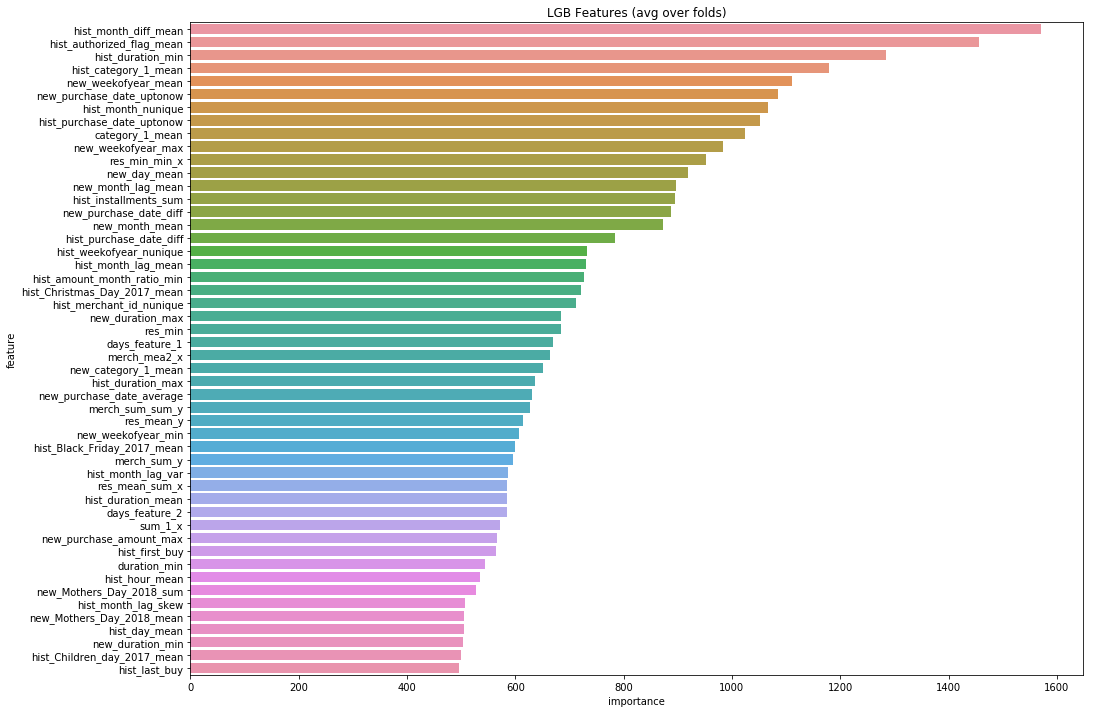

In [170]:
model, pred = model_train_easy(train_df, target, test_df)

In [92]:
train_df

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,std_1_y,merch_mea2_y,merch_sum2_y,merch_std2_y,merch_mean3_y,merch_sum3_y,merch_std3_y,merch_mean4_y,merch_sum4_y,merch_std4_y
0,0.013145,0.00875,0.011430,2,604,3020,0.008280,1208,0.003311,604,...,4.509537e+07,11209.431304,257816.92,12356.247446,9.713327e+05,22340653.17,1.316448e+06,105284.785813,2.421550e+06,113962.172227
1,0.010710,0.01138,0.010284,1,755,3020,0.005300,755,0.001325,0,...,3.948403e+06,4807.220000,28843.32,2700.639891,2.979447e+05,1787668.02,3.848267e+05,73000.896588,4.380054e+05,104690.304578
2,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,NaN,7145.310000,7145.31,NaN,9.433121e+04,94331.21,NaN,16046.130494,1.604613e+04,NaN
3,0.010710,0.01417,0.010284,3,512,2048,0.007812,1536,0.005860,0,...,2.487579e+07,9100.900000,63706.30,8962.990076,9.907792e+05,6935454.15,1.300491e+06,136229.368308,9.536056e+05,179481.730557
4,0.008060,0.01417,0.010284,4,451,451,0.002218,1353,0.006653,0,...,1.272737e+08,16996.785833,611884.29,26445.812398,1.645969e+06,59254895.53,5.053530e+06,135219.599044,4.867906e+06,321064.772988
5,0.010710,0.00875,0.010284,3,877,3508,0.004562,1754,0.002281,0,...,4.191736e+07,84714.875000,338859.50,164356.797995,2.995786e+06,11983145.43,4.199315e+06,259371.431269,1.037486e+06,392648.279964
6,0.010480,0.00875,0.011430,4,786,2358,0.003817,1572,0.002544,786,...,1.101847e+08,7702.988000,38514.94,7389.830554,1.963782e+06,9818908.56,3.007937e+06,113148.355718,5.657418e+05,120382.040737
7,0.010480,0.00875,0.011430,3,512,1536,0.005860,1024,0.003906,512,...,1.000111e+09,3935.426667,11806.28,3162.534116,3.131599e+06,9394795.63,5.228825e+06,122695.626075,3.680869e+05,160944.445721
8,0.010610,0.01138,0.010284,3,543,1086,0.003683,543,0.001842,0,...,8.213044e+05,5155.495000,10310.99,5646.876973,1.251967e+05,250393.31,2.021581e+04,27304.393328,5.460879e+04,9989.719753
9,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,3.400694e+06,4578.736667,13736.21,5055.246066,7.259186e+04,217775.57,3.468235e+04,15357.994019,4.607398e+04,6020.873429


In [ ]:
#########################################################################################################################

In [118]:
train_df_hep24 = train_df
test_df_hep24 = test_df

In [123]:
train_df = train_df_hep24
test_df = test_df_hep24

In [124]:
hist_merch = pd.DataFrame({'card_id': hist['card_id'], 'merch_id': hist['merchant_id'],
                          'purchase_amount': hist['purchase_amount'],
                          'month_lag': hist['month_lag']})
hist_merch.head(5)

,card_id,merch_id,purchase_amount,month_lag
0,C_ID_4e6213e9bc,M_ID_e020e9b302,29.00,-8
1,C_ID_4e6213e9bc,M_ID_86ec983688,9.17,-7
2,C_ID_4e6213e9bc,M_ID_979ed661fc,17.65,-6
3,C_ID_4e6213e9bc,M_ID_e6d5ae8ea6,7.69,-5
4,C_ID_4e6213e9bc,M_ID_e020e9b302,16.00,-11


In [35]:
hist

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,imputed_merchant_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,29.00,2017-06-25 15:33:07,1.0,16,37,NaN
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,9.17,2017-07-15 12:10:45,1.0,16,16,NaN
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,17.65,2017-08-09 22:04:29,1.0,16,37,NaN
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,7.69,2017-09-02 10:06:26,1.0,16,34,NaN
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,16.00,2017-03-10 01:14:19,1.0,16,37,NaN
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,8.00,2018-02-24 08:45:05,1.0,9,37,NaN
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,20.00,2017-03-21 00:10:51,1.0,16,37,NaN
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,59.80,2017-11-18 20:05:55,1.0,16,37,NaN
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,5.95,2017-06-01 22:02:56,1.0,16,37,NaN
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,21.00,2017-03-16 15:41:22,1.0,16,37,NaN


In [125]:
hist_lag0 = hist[hist['month_lag'] == 0].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag0.columns = ['merchant_id', 'lag0_mean', 'lag0_sum']

hist_lag1 = hist[hist['month_lag'] == -1].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag1.columns = ['merchant_id','lag1_mean', 'lag1_sum']

hist_lag2 = hist[hist['month_lag'] == -2].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag2.columns = ['merchant_id','lag2_mean', 'lag2_sum']

hist_lag3 = hist[hist['month_lag'] == -3].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag3.columns = ['merchant_id','lag3_mean', 'lag3_sum']

hist_lag4 = hist[hist['month_lag'] == -4].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag4.columns = ['merchant_id','lag4_mean', 'lag4_sum']

hist_lag5 = hist[hist['month_lag'] == -5].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag5.columns = ['merchant_id','lag5_mean', 'lag5_sum']

hist_lag6 = hist[hist['month_lag'] == -6].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag6.columns = ['merchant_id','lag6_mean', 'lag6_sum']

hist_lag7 = hist[hist['month_lag'] == -7].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag7.columns = ['merchant_id','lag7_mean', 'lag7_sum']

hist_lag8 = hist[hist['month_lag'] == -8].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag8.columns = ['merchant_id','lag8_mean', 'lag8_sum']

hist_lag9 = hist[hist['month_lag'] == -9].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag9.columns = ['merchant_id','lag9_mean', 'lag9_sum']

hist_lag10 = hist[hist['month_lag'] == -10].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag10.columns = ['merchant_id','lag10_mean', 'lag10_sum']

hist_lag11 = hist[hist['month_lag'] == -11].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag11.columns = ['merchant_id','lag11_mean', 'lag11_sum']

hist_lag12 = hist[hist['month_lag'] == -12].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag12.columns = ['merchant_id','lag12_mean', 'lag12_sum']

hist_lag13 = hist[hist['month_lag'] == -13].groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
hist_lag13.columns = ['merchant_id','lag13_mean', 'lag13_sum']


new_purch = new.groupby('merchant_id')['purchase_amount'].agg(['mean', 'sum']).reset_index()
new_purch.columns = ['merchant_id', 'new_mean', 'new_sum']


In [126]:
new_hist_lag0 = pd.merge(new_purch, hist_lag0, on='merchant_id', how='left')
new_hist_lag0['res_mean_0'] = new_hist_lag0['new_mean'] / new_hist_lag0['lag0_mean']
new_hist_lag0['res_sum_0'] = new_hist_lag0['new_sum'] / new_hist_lag0['lag0_sum']

new_hist_lag0['res_mean_sum_0'] = new_hist_lag0['new_mean'] / new_hist_lag0['lag0_sum']

lag_0 = pd.DataFrame({'merchant_id': new_hist_lag0['merchant_id'], 
                      'res_mean_0': new_hist_lag0['res_mean_0'], 'res_sum_0': new_hist_lag0['res_sum_0'],
                    'res_mean_sum_0': new_hist_lag0['res_mean_sum_0'] })
lag_0.fillna(lag_0.iloc[:, 1:].median(), inplace=True)


In [127]:
new_hist_lag1 = pd.merge(new_purch, hist_lag1, on='merchant_id', how='left')
new_hist_lag1['res_mean_1'] = new_hist_lag1['new_mean'] / new_hist_lag1['lag1_mean']
new_hist_lag1['res_sum_1'] = new_hist_lag1['new_sum'] / new_hist_lag1['lag1_sum']

new_hist_lag1['res_mean_sum_1'] = new_hist_lag1['new_mean'] / new_hist_lag1['lag1_sum']

lag_1 = pd.DataFrame({'merchant_id': new_hist_lag1['merchant_id'], 
                      'res_mean_1': new_hist_lag1['res_mean_1'], 'res_sum_1': new_hist_lag1['res_sum_1'],
                     'res_mean_sum_1': new_hist_lag1['res_mean_sum_1'] })
lag_1.fillna(lag_1.iloc[:, 1:].median(), inplace=True)

In [128]:
new_hist_lag2 = pd.merge(new_purch, hist_lag2, on='merchant_id', how='left')
new_hist_lag2['res_mean_2'] = new_hist_lag2['new_mean'] / new_hist_lag2['lag2_mean']
new_hist_lag2['res_sum_2'] = new_hist_lag2['new_sum'] / new_hist_lag2['lag2_sum']

new_hist_lag2['res_mean_sum_2'] = new_hist_lag2['new_mean'] / new_hist_lag2['lag2_sum']

lag_2 = pd.DataFrame({'merchant_id': new_hist_lag2['merchant_id'], 
                      'res_mean_2': new_hist_lag2['res_mean_2'], 'res_sum_2': new_hist_lag2['res_sum_2'],
                    'res_mean_sum_2': new_hist_lag2['res_mean_sum_2'] })
lag_2.fillna(lag_2.iloc[:, 1:].median(), inplace=True)

In [129]:
new_hist_lag3 = pd.merge(new_purch, hist_lag3, on='merchant_id', how='left')
new_hist_lag3['res_mean_3'] = new_hist_lag3['new_mean'] / new_hist_lag3['lag3_mean']
new_hist_lag3['res_sum_3'] = new_hist_lag3['new_sum'] / new_hist_lag3['lag3_sum']

new_hist_lag3['res_mean_sum_3'] = new_hist_lag3['new_mean'] / new_hist_lag3['lag3_sum']

lag_3 = pd.DataFrame({'merchant_id': new_hist_lag3['merchant_id'], 
                      'res_mean_3': new_hist_lag3['res_mean_3'], 'res_sum_3': new_hist_lag3['res_sum_3'],
                    'res_mean_sum_3': new_hist_lag3['res_mean_sum_3'] })
lag_3.fillna(lag_3.iloc[:, 1:].median(), inplace=True)

In [130]:
new_hist_lag4 = pd.merge(new_purch, hist_lag4, on='merchant_id', how='left')
new_hist_lag4['res_mean_4'] = new_hist_lag4['new_mean'] / new_hist_lag4['lag4_mean']
new_hist_lag4['res_sum_4'] = new_hist_lag4['new_sum'] / new_hist_lag4['lag4_sum']

new_hist_lag4['res_mean_sum_4'] = new_hist_lag4['new_mean'] / new_hist_lag4['lag4_sum']

lag_4 = pd.DataFrame({'merchant_id': new_hist_lag4['merchant_id'], 
                      'res_mean_4': new_hist_lag4['res_mean_4'], 'res_sum_4': new_hist_lag4['res_sum_4'],
                    'res_mean_sum_4': new_hist_lag4['res_mean_sum_4'] })
lag_4.fillna(lag_4.iloc[:, 1:].median(), inplace=True)

In [131]:
new_hist_lag5 = pd.merge(new_purch, hist_lag5, on='merchant_id', how='left')
new_hist_lag5['res_mean_5'] = new_hist_lag5['new_mean'] / new_hist_lag5['lag5_mean']
new_hist_lag5['res_sum_5'] = new_hist_lag5['new_sum'] / new_hist_lag5['lag5_sum']

new_hist_lag5['res_mean_sum_5'] = new_hist_lag5['new_mean'] / new_hist_lag5['lag5_sum']

lag_5 = pd.DataFrame({'merchant_id': new_hist_lag5['merchant_id'], 
                      'res_mean_5': new_hist_lag5['res_mean_5'], 'res_sum_5': new_hist_lag5['res_sum_5'],
                    'res_mean_sum_5': new_hist_lag5['res_mean_sum_5'] })
lag_5.fillna(lag_5.iloc[:, 1:].median(), inplace=True)

In [132]:
new_hist_lag6 = pd.merge(new_purch, hist_lag6, on='merchant_id', how='left')
new_hist_lag6['res_mean_6'] = new_hist_lag6['new_mean'] / new_hist_lag6['lag6_mean']
new_hist_lag6['res_sum_6'] = new_hist_lag6['new_sum'] / new_hist_lag6['lag6_sum']

new_hist_lag6['res_mean_sum_6'] = new_hist_lag6['new_mean'] / new_hist_lag6['lag6_sum']

lag_6 = pd.DataFrame({'merchant_id': new_hist_lag6['merchant_id'], 
                      'res_mean_6': new_hist_lag6['res_mean_6'], 'res_sum_6': new_hist_lag6['res_sum_6'],
                    'res_mean_sum_6': new_hist_lag6['res_mean_sum_6'] })
lag_6.fillna(lag_6.iloc[:, 1:].median(), inplace=True)

In [133]:
new_hist_lag7 = pd.merge(new_purch, hist_lag7, on='merchant_id', how='left')
new_hist_lag7['res_mean_7'] = new_hist_lag7['new_mean'] / new_hist_lag7['lag7_mean']
new_hist_lag7['res_sum_7'] = new_hist_lag7['new_sum'] / new_hist_lag7['lag7_sum']

new_hist_lag7['res_mean_sum_7'] = new_hist_lag7['new_mean'] / new_hist_lag7['lag7_sum']

lag_7 = pd.DataFrame({'merchant_id': new_hist_lag7['merchant_id'], 
                      'res_mean_7': new_hist_lag7['res_mean_7'], 'res_sum_7': new_hist_lag7['res_sum_7'],
                    'res_mean_sum_7': new_hist_lag7['res_mean_sum_7'] })
lag_7.fillna(lag_7.iloc[:, 1:].median(), inplace=True)

In [134]:
new_hist_lag8 = pd.merge(new_purch, hist_lag8, on='merchant_id', how='left')
new_hist_lag8['res_mean_8'] = new_hist_lag8['new_mean'] / new_hist_lag8['lag8_mean']
new_hist_lag8['res_sum_8'] = new_hist_lag8['new_sum'] / new_hist_lag8['lag8_sum']

new_hist_lag8['res_mean_sum_8'] = new_hist_lag8['new_mean'] / new_hist_lag8['lag8_sum']

lag_8 = pd.DataFrame({'merchant_id': new_hist_lag8['merchant_id'], 
                      'res_mean_8': new_hist_lag8['res_mean_8'], 'res_sum_8': new_hist_lag8['res_sum_8'],
                    'res_mean_sum_8': new_hist_lag8['res_mean_sum_8'] })
lag_8.fillna(lag_8.iloc[:, 1:].median(), inplace=True)

In [135]:
new_hist_lag9 = pd.merge(new_purch, hist_lag9, on='merchant_id', how='left')
new_hist_lag9['res_mean_9'] = new_hist_lag9['new_mean'] / new_hist_lag9['lag9_mean']
new_hist_lag9['res_sum_9'] = new_hist_lag9['new_sum'] / new_hist_lag9['lag9_sum']

new_hist_lag9['res_mean_sum_9'] = new_hist_lag9['new_mean'] / new_hist_lag9['lag9_sum']

lag_9 = pd.DataFrame({'merchant_id': new_hist_lag9['merchant_id'], 
                      'res_mean_9': new_hist_lag9['res_mean_9'], 'res_sum_9': new_hist_lag9['res_sum_9'],
                    'res_mean_sum_9': new_hist_lag9['res_mean_sum_9'] })
lag_9.fillna(lag_9.iloc[:, 1:].median(), inplace=True)

In [136]:
new_hist_lag10 = pd.merge(new_purch, hist_lag10, on='merchant_id', how='left')
new_hist_lag10['res_mean_10'] = new_hist_lag10['new_mean'] / new_hist_lag10['lag10_mean']
new_hist_lag10['res_sum_10'] = new_hist_lag10['new_sum'] / new_hist_lag10['lag10_sum']

new_hist_lag10['res_mean_sum_10'] = new_hist_lag10['new_mean'] / new_hist_lag10['lag10_sum']

lag_10 = pd.DataFrame({'merchant_id': new_hist_lag10['merchant_id'], 
                      'res_mean_10': new_hist_lag10['res_mean_10'], 'res_sum_10': new_hist_lag10['res_sum_10'],
                    'res_mean_sum_10': new_hist_lag10['res_mean_sum_10'] })
lag_10.fillna(lag_10.iloc[:, 1:].median(), inplace=True)

In [137]:
new_hist_lag11 = pd.merge(new_purch, hist_lag11, on='merchant_id', how='left')
new_hist_lag11['res_mean_11'] = new_hist_lag11['new_mean'] / new_hist_lag11['lag11_mean']
new_hist_lag11['res_sum_11'] = new_hist_lag11['new_sum'] / new_hist_lag11['lag11_sum']

new_hist_lag11['res_mean_sum_11'] = new_hist_lag11['new_mean'] / new_hist_lag11['lag11_sum']

lag_11 = pd.DataFrame({'merchant_id': new_hist_lag11['merchant_id'], 
                      'res_mean_11': new_hist_lag11['res_mean_11'], 'res_sum_11': new_hist_lag11['res_sum_11'],
                    'res_mean_sum_11': new_hist_lag11['res_mean_sum_11'] })
lag_11.fillna(lag_11.iloc[:, 1:].median(), inplace=True)

In [138]:
new_hist_lag12 = pd.merge(new_purch, hist_lag12, on='merchant_id', how='left')
new_hist_lag12['res_mean_12'] = new_hist_lag12['new_mean'] / new_hist_lag12['lag12_mean']
new_hist_lag12['res_sum_12'] = new_hist_lag12['new_sum'] / new_hist_lag12['lag12_sum']

new_hist_lag12['res_mean_sum_12'] = new_hist_lag12['new_mean'] / new_hist_lag12['lag12_sum']

lag_12 = pd.DataFrame({'merchant_id': new_hist_lag12['merchant_id'], 
                      'res_mean_12': new_hist_lag12['res_mean_12'], 'res_sum_12': new_hist_lag12['res_sum_12'],
                    'res_mean_sum_12': new_hist_lag12['res_mean_sum_12'] })
lag_12.fillna(lag_12.iloc[:, 1:].median(), inplace=True)

In [139]:
new_hist_lag13 = pd.merge(new_purch, hist_lag13, on='merchant_id', how='left')
new_hist_lag13['res_mean_13'] = new_hist_lag13['new_mean'] / new_hist_lag13['lag13_mean']
new_hist_lag13['res_sum_13'] = new_hist_lag13['new_sum'] / new_hist_lag13['lag13_sum']

new_hist_lag13['res_mean_sum_13'] = new_hist_lag13['new_mean'] / new_hist_lag13['lag13_sum']

lag_13 = pd.DataFrame({'merchant_id': new_hist_lag13['merchant_id'], 
                      'res_mean_13': new_hist_lag13['res_mean_13'], 'res_sum_13': new_hist_lag13['res_sum_13'],
                    'res_mean_sum_13': new_hist_lag13['res_mean_sum_13'] })
lag_13.fillna(lag_13.iloc[:, 1:].median(), inplace=True)

In [140]:
lag_0.shape[0] + lag_1.shape[0] + lag_2.shape[0] + lag_3.shape[0] + lag_4.shape[0] + lag_5.shape[0] \
+ lag_6.shape[0] + lag_7.shape[0]+ lag_8.shape[0] + lag_9.shape[0] + lag_10.shape[0] + lag_11.shape[0] \
+ lag_12.shape[0] + lag_13.shape[0]

3165806

In [141]:
lag = pd.concat([lag_0, lag_1, lag_2, lag_3, lag_4, lag_5,
                 lag_6, lag_7, lag_8, lag_9, lag_10, lag_11, lag_12, lag_13], axis=0)




In [142]:
lag['res_mean'] = 0

sc2 = lag_0.shape[0]
lag['res_mean'].iloc[:sc2] = lag['res_mean_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_mean'].iloc[sc1:sc2] = lag['res_mean_13'].iloc[sc1:sc2]

# lag['res_mean'].iloc[lag_4.shape[0]:lag_5.shape[0]] = lag['res_mean_5'].iloc[lag_4.shape[0]:lag_5.shape[0]]
# lag['res_mean'].iloc[lag_5.shape[0]:lag_6.shape[0]] = lag['res_mean_6'].iloc[lag_5.shape[0]:lag_6.shape[0]]
# lag['res_mean'].iloc[lag_6.shape[0]:lag_7.shape[0]] = lag['res_mean_7'].iloc[lag_6.shape[0]:lag_7.shape[0]]
# lag['res_mean'].iloc[lag_7.shape[0]:lag_8.shape[0]] = lag['res_mean_8'].iloc[lag_7.shape[0]:lag_8.shape[0]]
# lag['res_mean'].iloc[lag_8.shape[0]:lag_9.shape[0]] = lag['res_mean_9'].iloc[lag_8.shape[0]:lag_9.shape[0]]
# lag['res_mean'].iloc[lag_9.shape[0]:lag_10.shape[0]] = lag['res_mean_10'].iloc[lag_9.shape[0]:lag_10.shape[0]]
# lag['res_mean'].iloc[lag_10.shape[0]:lag_11.shape[0]] = lag['res_mean_11'].iloc[lag_10.shape[0]:lag_11.shape[0]]
# lag['res_mean'].iloc[lag_11.shape[0]:lag_12.shape[0]] = lag['res_mean_12'].iloc[lag_11.shape[0]:lag_12.shape[0]]
# lag['res_mean'].iloc[lag_11.shape[0]:lag_13.shape[0]] = lag['res_mean_13'].iloc[lag_12.shape[0]:lag_13.shape[0]]

In [143]:
lag['res_sum'] = 0

sc2 = lag_0.shape[0]
lag['res_sum'].iloc[:sc2] = lag['res_sum_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_sum'].iloc[sc1:sc2] = lag['res_sum_13'].iloc[sc1:sc2]

In [144]:
lag['res_mean_sum'] = 0

sc2 = lag_0.shape[0]
lag['res_mean_sum'].iloc[:sc2] = lag['res_mean_sum_0'].iloc[:sc2]

sc1 = lag_0.shape[0]
sc2 = sc1 + lag_1.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_1'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_2.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_2'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_3.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_3'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_4.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_4'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_5.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_5'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_6.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_6'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_7.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_7'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_8.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_8'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_9.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_9'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_10.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_10'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_11.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_11'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_12.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_12'].iloc[sc1:sc2]

sc1 = sc2
sc2 = sc2 + lag_13.shape[0]
lag['res_mean_sum'].iloc[sc1:sc2] = lag['res_mean_sum_13'].iloc[sc1:sc2]

In [145]:
lag_f = lag.groupby('merchant_id')['res_mean'].agg(['mean', 'sum', 'max', 'min', 'std']).reset_index()
lag_f.columns = ['merchant_id', 'res_mean', 'res_sum', 'res_max', 'res_min', 'res_std']

lag_f_sum = lag.groupby('merchant_id')['res_sum'].agg(['mean', 'sum' ,'max', 'min', 'std']).reset_index()
lag_f_sum.columns = ['merchant_id', 'res_mean_sum', 'res_sum_sum', 'res_max_max', 'res_min_min', 'res_std_std']

lag_f_mean_sum = lag.groupby('merchant_id')['res_mean_sum'].agg(['mean', 'sum',  'max', 'min', 'std']).reset_index()
lag_f_mean_sum.columns = ['merchant_id', 'res_mean_sum_1', 'res_sum_sum_1', 'res_max_1', 'res_min_1', 'res_std_1']

lag_f.head(5)

,merchant_id,res_mean,res_sum,res_max,res_min,res_std
0,M_ID_000025127f,2135.936193,29903.106704,6866.276364,691.570654,1952.521023
1,M_ID_0000699140,720.099689,10081.395650,1510.300167,276.274421,306.107840
2,M_ID_000087311e,576.374973,8069.249626,3017.513103,52.337249,766.518057
3,M_ID_0000ab0b2d,813.021540,11382.301565,1734.198463,125.073104,494.160884
4,M_ID_0000edb21f,705.361867,9875.066138,2055.699010,171.093955,486.584991


In [146]:
hist_merch.columns = ['card_id', 'merchant_id', 'purchase_amount', 'month_lag']

In [147]:
merch_lag = pd.merge(hist_merch, lag_f, on='merchant_id', how='left')

In [148]:
merch_lag_card_mean = merch_lag.groupby('card_id')['res_mean'].agg(['mean', 'sum']).reset_index()
merch_lag_card.columns = ['card_id', 'res_mean_mean_merch', 'res_mean_sum_merch']

merch_lag_card_sum = merch_lag.groupby('card_id')['res_sum'].agg(['mean', 'sum']).reset_index()
merch_lag_card_sum.columns = ['card_id', 'res_sum_mean_merch', 'res_sum_sum_merch']

merch_lag_card_max = merch_lag.groupby('card_id')['res_max'].agg(['mean', 'sum']).reset_index()
merch_lag_card_max.columns = ['card_id', 'res_max_mean_merch', 'res_max_sum_merch']

merch_lag_card_min = merch_lag.groupby('card_id')['res_min'].agg(['mean', 'sum']).reset_index()
merch_lag_card_min.columns = ['card_id', 'res_min_mean_merch', 'res_min_sum_merch']

merch_lag_card_std = merch_lag.groupby('card_id')['res_std'].agg(['mean', 'sum']).reset_index()
merch_lag_card_std.columns = ['card_id', 'res_std_mean_merch', 'res_std_sum_merch']


In [122]:
merch_lag_card_sum

['card_id', 'res_sum_mean_merch', 'res_sum_sum_merch']

In [149]:
train_df, test_df = add_card_id()

In [150]:
train_df = pd.merge(train_df, merch_lag_card_mean, on='card_id', how='left')
test_df = pd.merge(test_df, merch_lag_card_mean, on='card_id', how='left')

train_df = pd.merge(train_df, merch_lag_card_sum, on='card_id', how='left')
test_df = pd.merge(test_df, merch_lag_card_sum, on='card_id', how='left')

train_df = pd.merge(train_df, merch_lag_card_max, on='card_id', how='left')
test_df = pd.merge(test_df, merch_lag_card_max, on='card_id', how='left')

train_df = pd.merge(train_df, merch_lag_card_min, on='card_id', how='left')
test_df = pd.merge(test_df, merch_lag_card_min, on='card_id', how='left')

train_df = pd.merge(train_df, merch_lag_card_std, on='card_id', how='left')
test_df = pd.merge(test_df, merch_lag_card_std, on='card_id', how='left')


train_df.head(5)

,feature_1,feature_2,feature_3,quarter,elapsed_time,days_feature_1,days_feature_1_ratio,days_feature_2,days_feature_2_ratio,days_feature_3,...,mean,sum,res_sum_mean_merch,res_sum_sum_merch,res_max_mean_merch,res_max_sum_merch,res_min_mean_merch,res_min_sum_merch,res_std_mean_merch,res_std_sum_merch
0,0.013145,0.00875,0.011430,2,604,3020,0.008280,1208,0.003311,604,...,935.687698,239536.050730,13099.627774,3.353505e+06,2378.433390,608878.947853,284.789305,72906.062027,664.441861,170097.116382
1,0.010710,0.01138,0.010284,1,755,3020,0.005300,755,0.001325,0,...,724.109532,250541.897955,10137.533443,3.507587e+06,1121.377849,387996.735770,340.620213,117854.593702,224.277710,77600.087693
2,0.010610,0.00875,0.010284,3,908,1816,0.002203,1816,0.002203,0,...,713.759399,30691.654139,9992.631580,4.296832e+05,961.316498,41336.609409,534.022658,22962.974293,113.927162,4898.867957
3,0.010710,0.01417,0.010284,3,512,2048,0.007812,1536,0.005860,0,...,755.864004,58201.528292,10582.096053,8.148214e+05,1140.971377,87854.796009,451.620371,34774.768537,191.107257,14715.258788
4,0.008060,0.01417,0.010284,4,451,451,0.002218,1353,0.006653,0,...,873.443272,113547.625408,12228.205813,1.589667e+06,1785.615294,232129.988190,554.524605,72088.198614,338.112893,43954.676042


In [154]:
train_df, test_df = drop_card_id()

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.71936
[200]	training's rmse: 3.6553
[300]	training's rmse: 3.61735
[400]	training's rmse: 3.5912
[500]	training's rmse: 3.57143
[600]	training's rmse: 3.55498
[700]	training's rmse: 3.54088
[800]	training's rmse: 3.52825
[900]	training's rmse: 3.51665
[1000]	training's rmse: 3.50604
[1100]	training's rmse: 3.49606
[1200]	training's rmse: 3.48662
[1300]	training's rmse: 3.47765
[1400]	training's rmse: 3.46944
[1500]	training's rmse: 3.46054
[1600]	training's rmse: 3.45197
[1700]	training's rmse: 3.4434
[1800]	training's rmse: 3.43512
[1900]	training's rmse: 3.42749
[2000]	training's rmse: 3.41938
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.41938


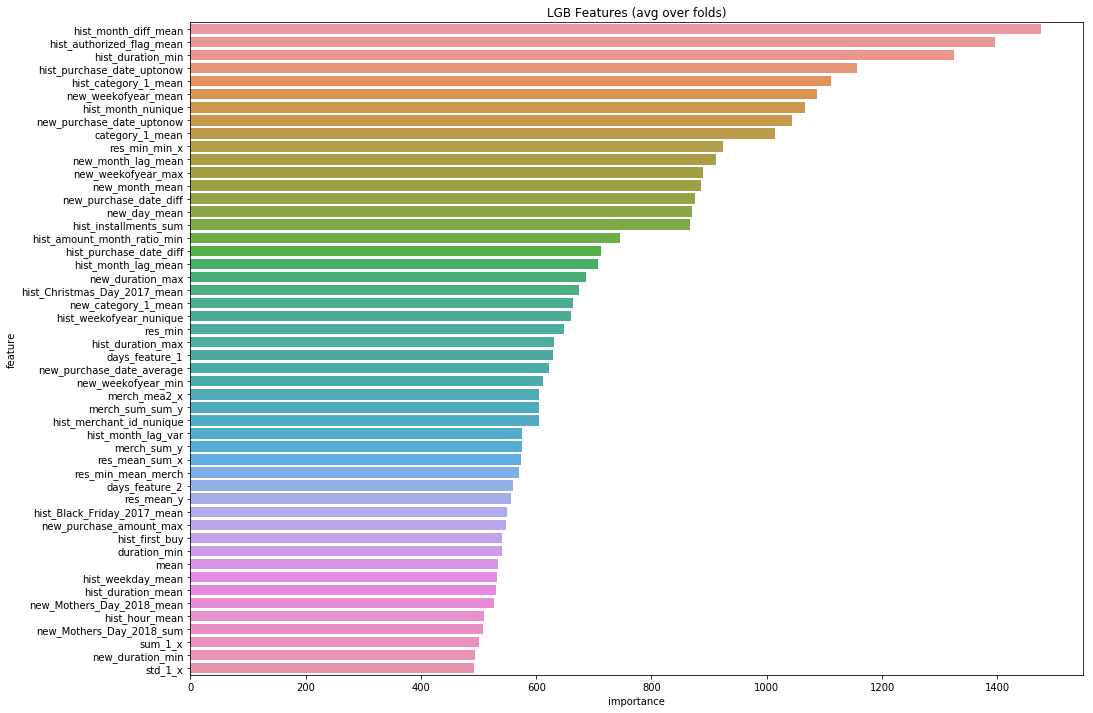

In [155]:
pred, model = model_train_easy(train_df, target, test_df)


In [ ]:
###############################

In [75]:
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(train_df.median(), inplace=True)

Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 3.7214
[200]	training's rmse: 3.65844
[300]	training's rmse: 3.62124
[400]	training's rmse: 3.59586
[500]	training's rmse: 3.57623
[600]	training's rmse: 3.56035
[700]	training's rmse: 3.54631
[800]	training's rmse: 3.53423
[900]	training's rmse: 3.52301
[1000]	training's rmse: 3.51291
[1100]	training's rmse: 3.50293
[1200]	training's rmse: 3.49338
[1300]	training's rmse: 3.48443
[1400]	training's rmse: 3.47633
[1500]	training's rmse: 3.46829
[1600]	training's rmse: 3.45991
[1700]	training's rmse: 3.45153
[1800]	training's rmse: 3.44302
[1900]	training's rmse: 3.43547
[2000]	training's rmse: 3.42737
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.42737


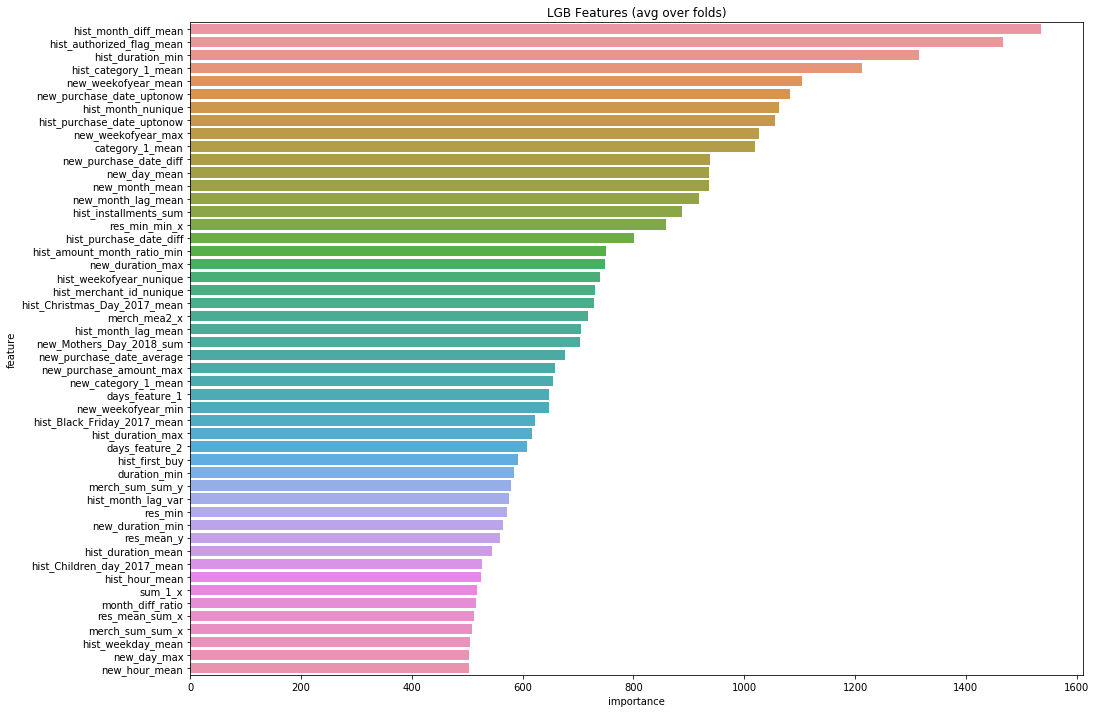

In [76]:
model, pred = model_train_easy(train_df, target, test_df)

In [ ]:
#########################################################################################################

## не сработало